# GAN overriding `Model.train_step`

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2020/04/29<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step`.

## Загрузка модулей

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## строим MNIST data

In [70]:
# MNIST 
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

## Строим discriminator

размер карты 28x28 и бинарная классификация (настоящее изображение или генерировано).

In [71]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d_12 (Glo (None, 128)             

## Строим generator

обратное по отношению к дискриминатору преобразование, меняем `Conv2D` на `Conv2DTranspose` .

In [73]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_72 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 14, 14, 128)       147584    
_________________________________________________________________
leaky_re_lu_73 (LeakyReLU)   (None, 14, 14, 128)       0 

## Класс со своим этапом обучения `train_step`

In [38]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


## Callback для сохранения изображений по ходу обучения

In [39]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


## Учим end-to-end модель

In [74]:
epochs = 10

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.3861 - g_loss: 5.4727
Epoch 2/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.1491 - g_loss: 4.8776
Epoch 3/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.6171 - g_loss: 1.2167
Epoch 4/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.5606 - g_loss: 1.3425
Epoch 5/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.5799 - g_loss: 1.2336
Epoch 6/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.5584 - g_loss: 1.2293
Epoch 7/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.5504 - g_loss: 1.2803
Epoch 8/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.5678 - g_loss: 1.2507
Epoch 9/10
1094/1094 [==============================] - 69s 63ms/step - d_loss: 0.5486 - g_loss: 1.3208
Epoch 10/10
1094/1094 [==============================] - 69s 63m

In [33]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/3
1094/1094 [==============================] - 67s 61ms/step - d_loss: 0.6190 - g_loss: 0.9921
Epoch 2/3
1094/1094 [==============================] - 67s 61ms/step - d_loss: 0.5998 - g_loss: 1.0484
Epoch 3/3
1094/1094 [==============================] - 67s 61ms/step - d_loss: 0.5682 - g_loss: 1.0866


Display the last generated images:

In [76]:
from IPython.display import Image, display

display(Image("generated_img_0_2.png"))
display(Image("generated_img_1_2.png"))
display(Image("generated_img_2_2.png"))

In [75]:
display(Image("generated_img_0_9.png"))
display(Image("generated_img_1_9.png"))
display(Image("generated_img_2_9.png"))

Изменение сложности сверточных слоев позволило немного улучшить качество создаваемого изображения.  Лучшее изображение выглядело следующим образом
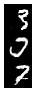



Возникли трудности с усложнением модели. Я старался добавить по 1 скрытому слою в дискриминатор и генератор. Это оченьб сильно усложняло модель и очень плохо сказывалось на качестве, иногда сети просто не обучались.  Проблема была в том, что невозможно было уменьшать размер изображения, более 2х раз. На первой итерации размер был 14*14, потом 7*7,а вот последующее уменьшение приводило к потере данных. Я пробовал использовать по 1 дополнительному слою, но без уменьшения размерности на 1 из слоев, но это давало ужасные результаты.

Увеличение количества эпох очень хорошо улучшало качество рабочей сети и выдаваемое изображение. 


Затем я перешел на fashion_mnist. Сеть вообще вела себя странно, за 3 эпохи она могла выдать очень красивое платье, а если переучить ее снова, то за 5 вообще что попало выдавало. Не совсем поянл, как это устроено. 

Начал эксперименты с добавлением дополнительного слоя в генератор. Добавил 1 слой в генератор, результат плохой. Добавил еще слой в дискриминатор, результат тоже плохой оказался. Код оставил последней попытки, может будут какие-то советы, что можно попытаться сделать, чтобы улучшить сеть? Оставил в ноутбуке самую удачную картинку из fashion mnist. В какой-то момент она была похожа на рубашку, но потом что-то переобучилось? 
